In [2]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.integrate import quad
from scipy import integrate as intg
import sympy as sp
from scipy import stats
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.stats import linregress
from scipy.stats import norm
import os
import seaborn as sns
from matplotlib import pyplot as plt, patches
#!pip statistics
import statistics


from astropy.table import Table

In [3]:
#!pip install git+https://github.com/mfouesneau/ezpadova
#import ezpadova

drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#r = ezpadova.get_isochrones(photsys_file='gaiaEDR3', logage=(6, 10, 0.2), MH=(-2, 1, 0.4))

Querying http://stev.oapd.inaf.it/cgi-bin/cmd...
Retrieving data...


# Reading in the Data


In [ ]:
#Open FITS file:
#hdu = fits.open('/content/drive/MyDrive/Chris and Punya Project/table_2_catwise.fits')
#hdu = fits.open('/content/drive/MyDrive/galactic project/Chris and Punya Project/table_2_catwise.fits')
hdu = fits.open('/content/drive/MyDrive/Chris and Punya Project/table_1_catwise.fits')

#/content/drive/MyDrive/Chris and Punya Project/table_2_catwise.fits
#An HDU (Header Data Unit) consist of a header and (typically) a data array or table.

#Check our HDU information, slices and cube:
print(hdu.info())
#header = hdu[0].header

data = hdu[1].data
#print(data.columns)


#print(list(header.keys()))




Filename: /content/drive/MyDrive/Chris and Punya Project/table_1_catwise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     22   174922161R x 7C   [K, D, D, L, D, D, D]   
None


In [ ]:

# --- PERFORM THE CUT ---
#below would be for table 2, where we have a lot more columns
#cols = ["source_id", "ra", "dec", "parallax",'phot_rp_mean_mag','phot_bp_mean_mag','parallax_error' ,"phot_g_mean_mag",'logg_xgboost','l','b','ra','dec']
#df = pd.DataFrame({c: data[c] for c in cols})
#df.head()
DATA = data#[:6000000]
cols = ["source_id",'mh_xgboost','teff_xgboost' ,"logg_xgboost"]
df = pd.DataFrame({c: DATA[c] for c in cols})
df.head()

# Function to fix byte order compatible with NumPy 2.0
def fix_bytes(arr):
    # 1. Swap the bytes (Big -> Little)
    swapped = arr.byteswap()
    # 2. View it with the correct little-endian dtype
    return swapped.view(swapped.dtype.newbyteorder('<'))

df = pd.DataFrame({
    c: fix_bytes(DATA[c])
    for c in cols
})
#df['absolutemagnitude'] = df['logg_xgboost'] - 5 * np.log10(1000 / df['parallax']) + 5
df2 = df[
    (df['logg_xgboost']  <= 4.11)
    & (df['logg_xgboost'] >= 3.8) &
    (df['mh_xgboost'] > -2)

]











#print(f"Rows before cut: {len(data):.2e}")
#print(f"Rows after cut: {len(df2):.2e}")




#print(list(header.keys()))

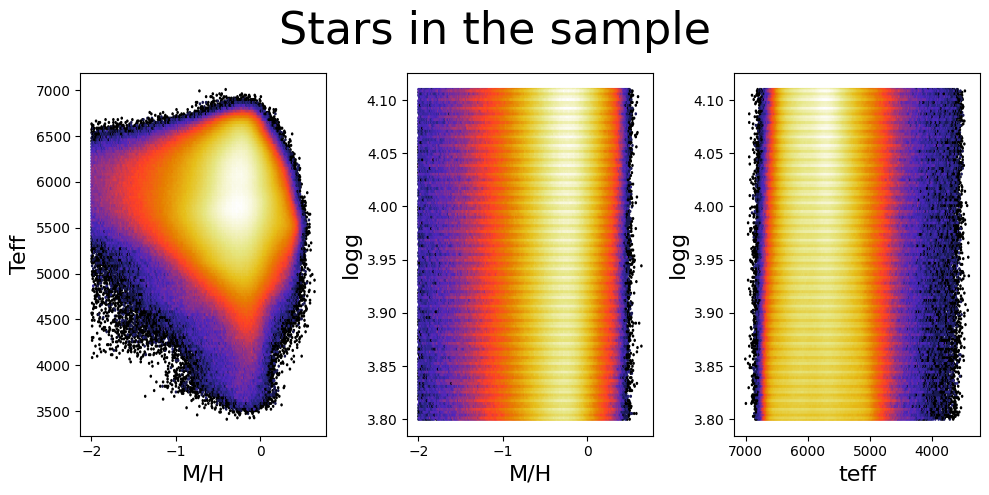

In [ ]:

logg = df2['logg_xgboost']
mh = df2["mh_xgboost"]
teff = df2["teff_xgboost"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
#plt.scatter(bp - rp, abs_g, s=1, alpha=0.3)
ax1.hexbin(mh, teff, cmap='CMRmap',gridsize=200, mincnt=1,bins='log')
ax1.set_xlabel("M/H",fontsize = 16)
ax1.set_ylabel("Teff",fontsize = 16)

ax2.hexbin(mh, logg, cmap='CMRmap',gridsize=200, mincnt=1,bins='log')
ax2.set_xlabel("M/H",fontsize = 16)
ax2.set_ylabel("logg",fontsize = 16)
#ax2.set_xlim(-2,1)


ax3.hexbin(teff, logg, cmap='CMRmap',gridsize=200, mincnt=1,bins='log')
ax3.set_xlabel("teff",fontsize = 16)
ax3.set_ylabel("logg",fontsize = 16)
#ax3.set_xlim(8000,3900)


plt.gca().invert_xaxis()

#plt1 = ax1.plot(teff,mh,cmap = 'CMRmap')
#plt3 = ax3.colorbar(z[r3], ax=ax3, label='N stars')
#plt2 = ax2.hist2d(z[r2],a[r2],bins=50, cmap = 'CMRmap')
#plt3 = ax3.hist2d(z[r3],a[r3],bins=50, cmap = 'CMRmap')

#cbar = plt.colorbar(plt3[3], ax=ax3)
#cbar.set_label('N stars', size =16)
#cbar = plt.colorbar(z[r3],ax=ax3,label='N stars')

#ax1.set_ylabel(r'[$\alpha$/Fe]', fontsize=16)
#ax2.set_xlabel('Z [Fe/H] ', fontsize=16)
plt.suptitle('Stars in the sample', fontsize = 32)
plt.tight_layout()
plt.show()

KeyError: 'phot_bp_mean_mag'

# START

In [4]:
file1_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-2to-1.5.dat'
file2_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-1.5to-1.dat'
file3_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-1to-0.5.dat'
file4_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-0.5to0.dat'
file5_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone0to0.5.dat'

In [5]:


# 2. Helper function to read the tricky PARSEC/MIST format
def read_isochrone(filepath):
    """
    Reads an isochrone file, finding the header line automatically
    even if it starts with '#'.
    """
    # First, find the header line inside the file
    with open(filepath, 'r') as f:
        for line in f:
            # We look for a unique column name like 'logAge' or 'Zini'
            if 'logAge' in line:
                # Remove '#', strip whitespace, and split into a list
                col_names = line.replace('#', '').strip().split()
                break

    # Now read the data using those column names
    df = pd.read_csv(
        filepath,
        sep='\s+',       # Reads whitespace-separated data
        comment='#',     # Skips the comment lines during data reading
        header=None,     # We supply headers manually
        names=col_names  # Use the names we found
    )
    return df

# 3. Load both files
iso_df1 = read_isochrone(file1_path)
iso_df2 = read_isochrone(file2_path)
iso_df3 = read_isochrone(file3_path)
iso_df4 = read_isochrone(file4_path)
iso_df5 = read_isochrone(file5_path)

# 4. Combine them into one
master_iso_df = pd.concat([iso_df1, iso_df2, iso_df3, iso_df4, iso_df5], ignore_index=True)

# 5. Verify the combination
print(f"File 1 shape: {iso_df1.shape}")
print(iso_df1.columns.tolist())
print(f"Combined shape: {master_iso_df.shape}")

# Optional: Sort by age so the data is continuous
master_iso_df = master_iso_df.sort_values(by=['logAge', 'Mini'])
master_iso_df.head()

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2921759101.py:19: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',       # Reads whitespace-separated data


File 1 shape: (67034, 37)
['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2', 'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPbrmag', 'G_BPftmag', 'G_RPmag', 'B_Tmag', 'V_Tmag', 'Jmag', 'Hmag', 'Ksmag']
Combined shape: (348661, 37)


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,mbolmag,Gmag,G_BPbrmag,G_BPftmag,G_RPmag,B_Tmag,V_Tmag,Jmag,Hmag,Ksmag
18014,0.000220,-1.85,8.0,0.09,1.08169,0.09,-2.565,3.5521,5.117,0,...,11.182,11.638,12.648,12.684,10.643,14.449,12.659,9.384,8.912,8.770
24119,0.000246,-1.80,8.0,0.09,1.08169,0.09,-2.569,3.5488,5.108,0,...,11.191,11.667,12.697,12.734,10.662,14.534,12.711,9.386,8.908,8.764
30219,0.000276,-1.75,8.0,0.09,1.08169,0.09,-2.573,3.5455,5.099,0,...,11.201,11.698,12.749,12.785,10.683,14.621,12.764,9.388,8.903,8.758
36338,0.000310,-1.70,8.0,0.09,1.08169,0.09,-2.577,3.5422,5.090,0,...,11.212,11.729,12.802,12.837,10.704,14.708,12.819,9.391,8.899,8.752
42462,0.000348,-1.65,8.0,0.09,1.08169,0.09,-2.581,3.5390,5.081,0,...,11.223,11.759,12.854,12.889,10.724,14.789,12.872,9.392,8.900,8.750


In [6]:
print(master_iso_df['logAge'].dtype)
print(master_iso_df['logAge'].unique())

float64
[ 8.       8.77815  9.04139  9.20412  9.32222  9.41497  9.49136  9.5563
  9.61278  9.66276  9.70757  9.74819  9.78533  9.81954  9.85126  9.88081
  9.90848  9.9345   9.95904  9.98227 10.00432 10.02531 10.04532 10.06446
 10.08279 10.10037]


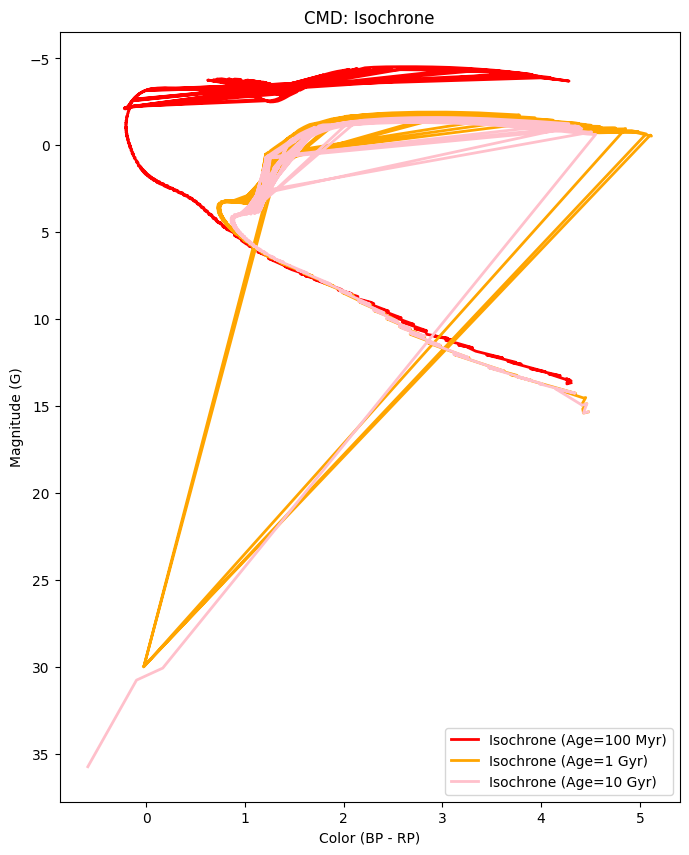

In [7]:
# Create Color and Magnitude columns for plotting
plt.figure(figsize=(8, 10))

# If Gmag is brighter (less) than 10.87, use 'br'. Otherwise, use 'ft'.
master_iso_df['G_BPmag'] = np.where(
    master_iso_df['Gmag'] < 10.87,
    master_iso_df['G_BPbrmag'],
    master_iso_df['G_BPftmag'])
master_iso_df['BP_RP'] = master_iso_df['G_BPmag'] - master_iso_df['G_RPmag']
master_iso_df['M_G'] = master_iso_df['Gmag']

subset_iso = master_iso_df[
    (master_iso_df['MH'] > -0.1) &
    (master_iso_df['MH'] < 0.1)]

# You often have many ages in one file. Filter for the specific age you want.
# Example: Select logAge = 8.0 (100 Million years)
one_iso8 = subset_iso[subset_iso['logAge'] == 8.0]

plt.plot(one_iso8['BP_RP'], one_iso8['M_G'],
         color='red', linewidth=2, label='Isochrone (Age=100 Myr)')
# Example: Select logAge = 9.0 (1 Billion years)
one_iso9 = subset_iso[subset_iso['logAge'] == 9.78533]

plt.plot(one_iso9['BP_RP'], one_iso9['M_G'],
         color='orange', linewidth=2, label='Isochrone (Age=1 Gyr)')
# Example: Select logAge = 10.0 (10 Billion years)
one_iso10 = subset_iso[subset_iso['logAge'] == 10.10037]

plt.plot(one_iso10['BP_RP'], one_iso10['M_G'],
         color='pink', linewidth=2, label='Isochrone (Age=10 Gyr)')

# --- Formatting the Graph ---
plt.gca().invert_yaxis()  # Magnitudes are reverse (brighter is lower number)
plt.xlabel('Color (BP - RP)')
plt.ylabel('Magnitude (G)')
plt.legend()
plt.title('CMD: Isochrone')

plt.show()

In [16]:
#file_path1 = '/Final Project/table_1_catwise.fits'
file_path1 = fits.open('/content/drive/MyDrive/Chris and Punya Project/table_1_catwise.fits')

print("Reading FITS file headers... (Data stays on disk)")
# memmap=True acts like a 'window' into the file without loading it all
t = Table.read(file_path1, format='fits', memmap=True)

# Print column names to verify (optional, good for debugging)
print("Columns found:", t.colnames)

# --- CRITICAL CHANGE: FILTER FIRST ---
print("Filtering for MSTO...")

# Define your MSTO Box
# Note: Astropy tables use ['colname'] just like pandas
condition = (
    (t['teff_xgboost'] >= 5000) &
    (t['teff_xgboost'] <= 6500) &
    (t['logg_xgboost'] >= 3.8) &
    (t['logg_xgboost'] <= 4.1) &
     (t['mh_xgboost'] > -2)
)

# Apply the filter. This creates a new, smaller table in memory.
MSTO_table = t[condition]

print(f"Reduced from {len(t)} stars to {len(MSTO_table)} MSTO stars.")

# --- NOW IT IS SAFE TO CONVERT ---
print("Converting to pandas...")
df1 = MSTO_table.to_pandas()

print("Done!")
df1.head()


Reading FITS file headers... (Data stays on disk)
Columns found: ['source_id', 'catwise_w1', 'catwise_w2', 'in_training_sample', 'mh_xgboost', 'teff_xgboost', 'logg_xgboost']
Filtering for MSTO...
Reduced from 174922161 stars to 19608730 MSTO stars.
Converting to pandas...
Done!


,source_id,catwise_w1,catwise_w2,in_training_sample,mh_xgboost,teff_xgboost,logg_xgboost
0,1653563247744,14.734,14.802,False,-1.286,6102.0,4.017
1,7834020517760,15.532,15.803,False,-0.420,5547.9,3.850
2,13473313244288,9.828,9.844,False,-0.144,6082.9,3.983
3,29278792888448,10.990,11.009,False,-0.262,5967.1,3.967
4,69067369899904,12.958,13.009,False,-0.395,5586.3,4.071


In [ ]:
#Bayesian
import numpy as np
import pandas as pd

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
sigma_teff = 50.0
sigma_logg = 0.08
sigma_mh   = 0.1

print("Preparing and sorting model grid...")
# Use Linear Kelvin for models
iso_models = master_iso_df.dropna(subset=['logTe', 'logg', 'MH', 'logAge']).copy()
iso_models = iso_models.sort_values(by='logTe')
iso_models = iso_models.iloc[::5]

iso_teff = 10**iso_models['logTe'].values # Linear Kelvin
iso_logg = iso_models['logg'].values
iso_mh   = iso_models['MH'].values
iso_age  = (10**iso_models['logAge'].values) / 1e9

print("Sorting star data...")
df1['orig_index'] = df1.index
df1 = df1.sort_values(by='logteff_xgboost')

# --- FIX IS HERE: Convert Log Teff to Linear Kelvin ---
stars_teff = 10**df1['logteff_xgboost'].values  # <--- CHANGED THIS
stars_logg = df1['logg_xgboost'].values
stars_mh   = df1['mh_xgboost'].values

final_ages = np.zeros(len(df1))
final_errors = np.zeros(len(df1))

# ==========================================
# 2. THE FAST LOOP (Binary Search Slicing)
# ==========================================
batch_size = 10000
num_stars = len(df1)
sigma_cut = 2.0

print(f"Starting Binary Search Analysis for {num_stars} stars...")

for i in range(0, num_stars, batch_size):
    end_idx = min(i + batch_size, num_stars)

    batch_teff = stars_teff[i:end_idx]
    batch_logg = stars_logg[i:end_idx]
    batch_mh   = stars_mh[i:end_idx]

    # 1. Binary Search Range
    min_search_val = np.min(batch_teff) - (sigma_cut * sigma_teff)
    max_search_val = np.max(batch_teff) + (sigma_cut * sigma_teff)

    start_iso = np.searchsorted(iso_teff, min_search_val, side='left')
    end_iso   = np.searchsorted(iso_teff, max_search_val, side='right')

    # --- DEBUG: Print this ONCE to ensure it's working ---
    if i == 0:
        print(f"DEBUG BATCH 0:")
        print(f"Star Temp Range: {np.min(batch_teff):.1f} K to {np.max(batch_teff):.1f} K")
        print(f"Search Range: {min_search_val:.1f} K to {max_search_val:.1f} K")
        print(f"Model Indices found: {start_iso} to {end_iso} (Total Models: {end_iso - start_iso})")
        if end_iso - start_iso == 0:
            print("CRITICAL WARNING: No models found in this range! Check units.")

    # Safety: Ensure we have data
    if end_iso <= start_iso:
        final_ages[i:end_idx] = np.nan
        final_errors[i:end_idx] = np.nan
        continue

    # 2. Slice Grid
    sub_iso_teff = iso_teff[start_iso:end_iso]
    sub_iso_logg = iso_logg[start_iso:end_iso]
    sub_iso_mh   = iso_mh[start_iso:end_iso]
    sub_iso_age  = iso_age[start_iso:end_iso]

    # 3. Bayes Math
    b_teff = batch_teff[:, np.newaxis]
    b_logg = batch_logg[:, np.newaxis]
    b_mh   = batch_mh[:, np.newaxis]

    chi2 = (
        ((b_teff - sub_iso_teff) / sigma_teff)**2 +
        ((b_logg - sub_iso_logg) / sigma_logg)**2 +
        ((b_mh   - sub_iso_mh)   / sigma_mh)**2
    )

    likelihood = np.exp(-0.5 * chi2)
    total_likelihood = np.sum(likelihood, axis=1)

    # Avoid div by zero
    mask_valid = total_likelihood > 0

    batch_ages = np.full(len(batch_teff), np.nan)
    batch_errs = np.full(len(batch_teff), np.nan)

    if np.any(mask_valid):
        # Normalize only valid stars
        norm_likelihood = likelihood[mask_valid] / total_likelihood[mask_valid][:, np.newaxis]

        batch_ages[mask_valid] = np.sum(sub_iso_age * norm_likelihood, axis=1)

        variance = np.sum(((sub_iso_age - batch_ages[mask_valid][:, np.newaxis])**2) * norm_likelihood, axis=1)
        batch_errs[mask_valid] = np.sqrt(variance)

    final_ages[i:end_idx] = batch_ages
    final_errors[i:end_idx] = batch_errs

    if i % 50000 == 0:
        print(f"Processed {i} / {num_stars} stars... (Slice size: {end_iso - start_iso})")

# ==========================================
# 3. RESTORE & SAVE
# ==========================================
df1['age_bayesian'] = final_ages
df1['age_error'] = final_errors
df1 = df1.sort_values(by='orig_index').drop(columns=['orig_index'])

print("Done! First 5 results:")
print(df1[['teff_xgboost', 'age_bayesian', 'age_error']].head())


NameError: name 'bp' is not defined

<Figure size 600x800 with 0 Axes>

In [17]:
'''
#df1.head()
#df1.to_csv('stars_with_ages.csv', index=False)

t = Table.from_pandas(df1)

# 2. Save to FITS
# overwrite=True ensures you don't get an error if you run this cell twice
t.write('stars_with_ages.fits', format='fits', overwrite=True)
'''

"\n#df1.head()\n#df1.to_csv('stars_with_ages.csv', index=False)\n\nt = Table.from_pandas(df1)\n\n# 2. Save to FITS\n# overwrite=True ensures you don't get an error if you run this cell twice\nt.write('stars_with_ages.fits', format='fits', overwrite=True)\n"

In [13]:
# Define the filename
file_path2 = '/content/drive/MyDrive/Chris and Punya Project/stars_with_ages.fits'

print("Reading FITS file... (this may take a moment)")
# Read the FITS file using astropy
# 'memmap=True' helps avoid loading the entire file into RAM at once during the read step
astro_table2 = Table.read(file_path2, format='fits', memmap=True)

# Convert to a pandas DataFrame for easier analysis
df1 = astro_table2.to_pandas()

print(df1.columns.tolist())
print(f"\nSuccessfully loaded {len(df1)} stars.")
df1.head()

Reading FITS file... (this may take a moment)
['source_id', 'catwise_w1', 'catwise_w2', 'in_training_sample', 'mh_xgboost', 'teff_xgboost', 'logg_xgboost', 'logteff_xgboost', 'age_bayesian', 'age_error']

Successfully loaded 19608730 stars.


,source_id,catwise_w1,catwise_w2,in_training_sample,mh_xgboost,teff_xgboost,logg_xgboost,logteff_xgboost,age_bayesian,age_error
0,1653563247744,14.734,14.802,False,-1.286,6102.0,4.017,3.785472,11.706428,1.066437
1,7834020517760,15.532,15.803,False,-0.420,5547.9,3.850,3.744129,8.483332,2.234548
2,13473313244288,9.828,9.844,False,-0.144,6082.9,3.983,3.784111,6.163980,0.983202
3,29278792888448,10.990,11.009,False,-0.262,5967.1,3.967,3.775763,7.850906,1.733987
4,69067369899904,12.958,13.009,False,-0.395,5586.3,4.071,3.747124,11.014741,1.342651


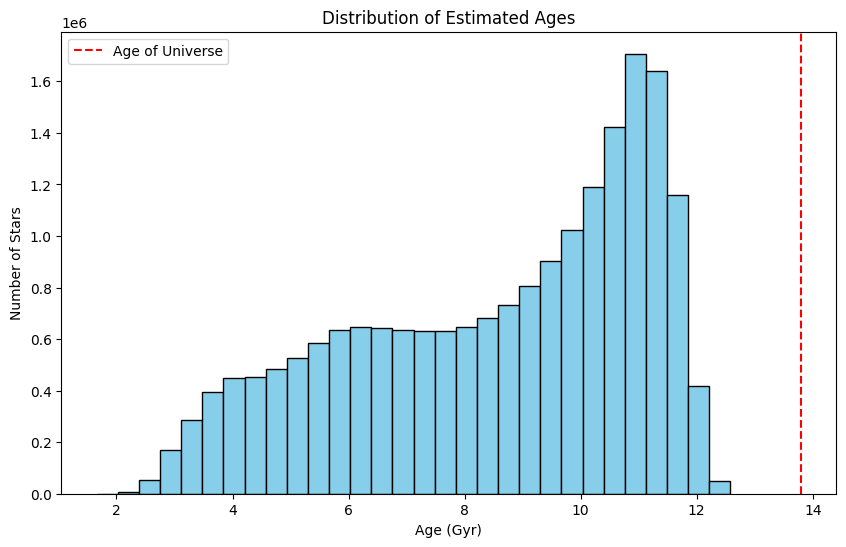

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df1['age_bayesian'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age (Gyr)')
plt.ylabel('Number of Stars')
plt.title('Distribution of Estimated Ages')
plt.axvline(x=13.8, color='red', linestyle='--', label='Age of Universe')
plt.legend()
plt.show()

Plotting 19608730 reliable stars...


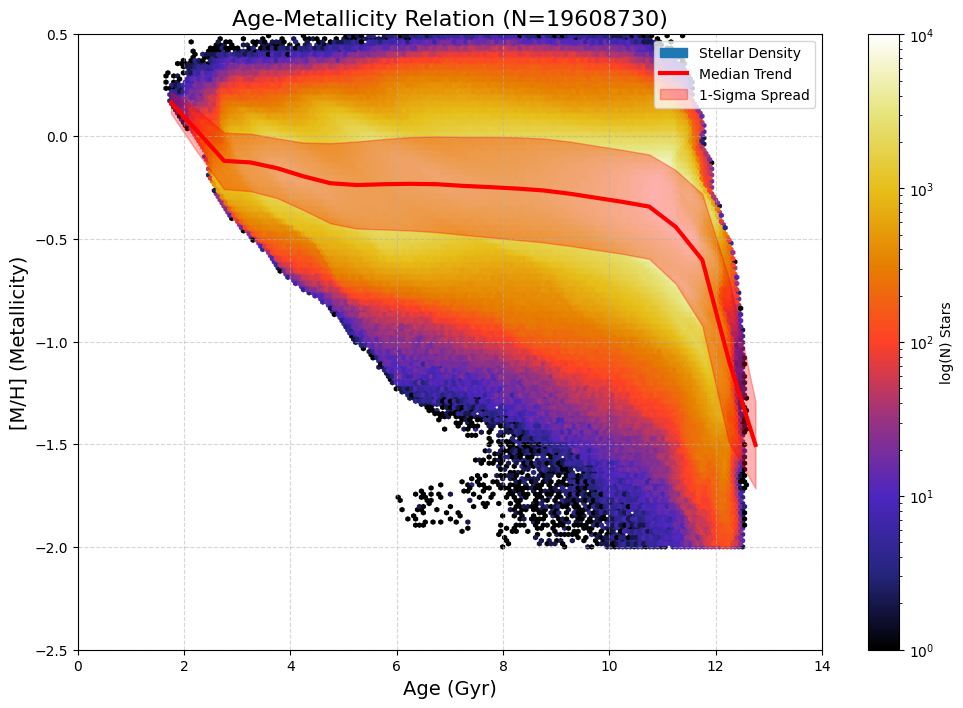

In [15]:
# 1. Select only the "Reliable" stars
# In the new code, failed fits are NaN, so we drop them.
# We also optionally filter out stars with huge error bars (e.g., > 4 Gyr)
good_df = df1.dropna(subset=['age_bayesian']).copy()
good_df = good_df[good_df['age_error'] < 4.0] # Optional: Clean up uncertain stars

print(f"Plotting {len(good_df)} reliable stars...")

plt.figure(figsize=(12, 8))

# 2. Plot the Density (Hexbin instead of Scatter)
# plotting 19 million scatter points would crash the memory.
# Hexbin creates a heatmap of stellar density.
hb = plt.hexbin(good_df['age_bayesian'], good_df['mh_xgboost'],
           gridsize=150,           # Resolution of the grid
           cmap='CMRmap',           # Black/White colormap
           mincnt=1,               # Don't plot empty bins
           bins='log',             # Logarithmic scale makes faint features visible
           label='Stellar Density')

# Add a colorbar to show density
cb = plt.colorbar(hb, label='log(N) Stars')

# 3. Calculate the Trend Line (Median Metallicity per Age Bin)
age_bins = np.arange(0, 15, 0.5) # 0.5 Gyr steps for better resolution
bin_centers = 0.5 * (age_bins[1:] + age_bins[:-1])

median_metallicity = []
std_metallicity = []

# We calculate stats on the FULL dataset, not just what's visible
for i in range(len(age_bins)-1):
    slice_mask = (good_df['age_bayesian'] >= age_bins[i]) & (good_df['age_bayesian'] < age_bins[i+1])
    stars_in_bin = good_df[slice_mask]

    if len(stars_in_bin) > 50: # Require 50 stars to calculate a median
        median_metallicity.append(stars_in_bin['mh_xgboost'].median())
        std_metallicity.append(stars_in_bin['mh_xgboost'].std())
    else:
        median_metallicity.append(np.nan)
        std_metallicity.append(np.nan)

# 4. Plot the Trend Line
plt.plot(bin_centers, median_metallicity, color='red', linewidth=3, label='Median Trend')

# Plot the "spread" (1-sigma) area
lower_bound = np.array(median_metallicity) - np.array(std_metallicity)
upper_bound = np.array(median_metallicity) + np.array(std_metallicity)
plt.fill_between(bin_centers, lower_bound, upper_bound, color='red', alpha=0.3, label='1-Sigma Spread')

# 5. Formatting
plt.xlabel('Age (Gyr)', fontsize=14)
plt.ylabel('[M/H] (Metallicity)', fontsize=14)
plt.title(f'Age-Metallicity Relation (N={len(good_df)})', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(0, 14)
plt.ylim(-2.5, 0.5)
plt.legend(loc='upper right')

plt.show()

# END



```
# This is formatted as code
```

# Isochrones


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 1. Define your file paths
file1_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-2to-1.5.dat'
file2_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-1.5to-1.dat'
file3_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-1to-0.5.dat'
file4_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-0.5to0.dat'
file5_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone0to0.5.dat'


# 2. Helper function to read the tricky PARSEC/MIST format
def read_isochrone(filepath):
    """
    Reads an isochrone file, finding the header line automatically
    even if it starts with '#'.
    """
    # First, find the header line inside the file
    with open(filepath, 'r') as f:
        for line in f:
            # We look for a unique column name like 'logAge' or 'Zini'
            if 'logAge' in line:
                # Remove '#', strip whitespace, and split into a list
                col_names = line.replace('#', '').strip().split()
                break

    # Now read the data using those column names
    df = pd.read_csv(
        filepath,
        sep='\s+',       # Reads whitespace-separated data
        comment='#',     # Skips the comment lines during data reading
        header=None,     # We supply headers manually
        names=col_names  # Use the names we found
    )
    return df

# 3. Load both files
iso_df1 = read_isochrone(file1_path)
iso_df2 = read_isochrone(file2_path)
iso_df3 = read_isochrone(file3_path)
iso_df4 = read_isochrone(file4_path)
iso_df5 = read_isochrone(file5_path)

# 4. Combine them into one
master_iso_df = pd.concat([iso_df1, iso_df2, iso_df3, iso_df4, iso_df5], ignore_index=True)

# 5. Verify the combination
print(f"File 1 shape: {iso_df1.shape}")
print(iso_df1.columns.tolist())
print(f"Combined shape: {master_iso_df.shape}")

# Optional: Sort by age so the data is continuous
master_iso_df = master_iso_df.sort_values(by=['logAge', 'Mass'])
master_iso_df.head()

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-398015681.py:29: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',       # Reads whitespace-separated data


File 1 shape: (67034, 37)
['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2', 'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPbrmag', 'G_BPftmag', 'G_RPmag', 'B_Tmag', 'V_Tmag', 'Jmag', 'Hmag', 'Ksmag']
Combined shape: (348661, 37)


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,mbolmag,Gmag,G_BPbrmag,G_BPftmag,G_RPmag,B_Tmag,V_Tmag,Jmag,Hmag,Ksmag
12001,0.000196,-1.90,8.0,0.090314,1.084689,0.09,-2.559,3.5554,5.126,0,...,11.166,11.603,12.593,12.630,10.618,14.357,12.602,9.378,8.910,8.770
18014,0.000220,-1.85,8.0,0.090000,1.081690,0.09,-2.565,3.5521,5.117,0,...,11.182,11.638,12.648,12.684,10.643,14.449,12.659,9.384,8.912,8.770
24119,0.000246,-1.80,8.0,0.090000,1.081690,0.09,-2.569,3.5488,5.108,0,...,11.191,11.667,12.697,12.734,10.662,14.534,12.711,9.386,8.908,8.764
30219,0.000276,-1.75,8.0,0.090000,1.081690,0.09,-2.573,3.5455,5.099,0,...,11.201,11.698,12.749,12.785,10.683,14.621,12.764,9.388,8.903,8.758
36338,0.000310,-1.70,8.0,0.090000,1.081690,0.09,-2.577,3.5422,5.090,0,...,11.212,11.729,12.802,12.837,10.704,14.708,12.819,9.391,8.899,8.752


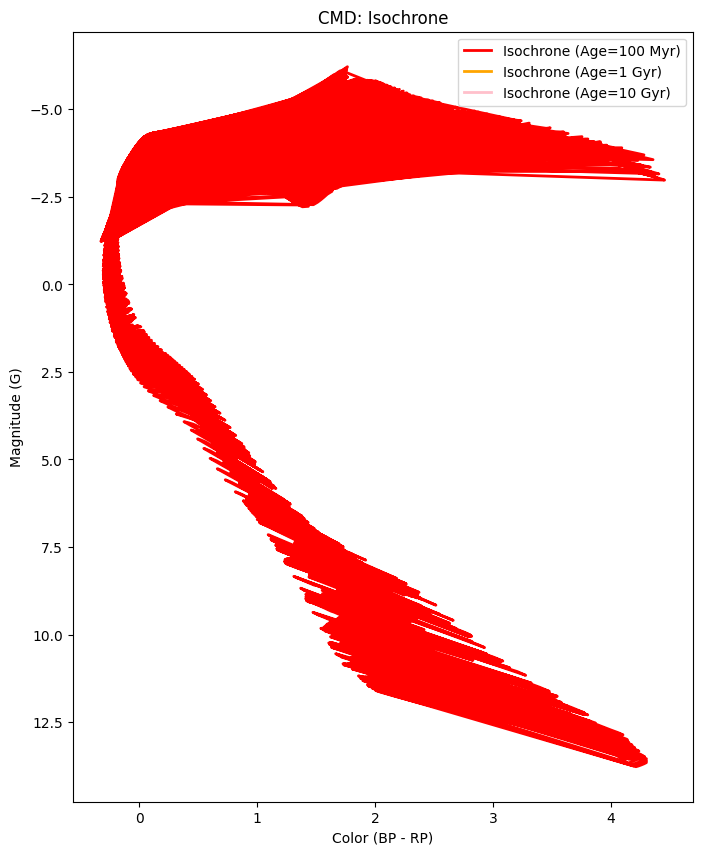

In [ ]:
# Create Color and Magnitude columns for plotting
plt.figure(figsize=(8, 10))

# If Gmag is brighter (less) than 10.87, use 'br'. Otherwise, use 'ft'.
master_iso_df['G_BPmag'] = np.where(
    master_iso_df['Gmag'] < 10.87,
    master_iso_df['G_BPbrmag'],
    master_iso_df['G_BPftmag'])
master_iso_df['BP_RP'] = master_iso_df['G_BPmag'] - master_iso_df['G_RPmag']
master_iso_df['M_G'] = master_iso_df['Gmag']

# You often have many ages in one file. Filter for the specific age you want.
# Example: Select logAge = 8.0 (100 Million years)
one_iso8 = master_iso_df[master_iso_df['logAge'] == 8.0]

plt.plot(one_iso8['BP_RP'], one_iso8['M_G'],
         color='red', linewidth=2, label='Isochrone (Age=100 Myr)')
# Example: Select logAge = 9.0 (1 Billion years)
one_iso9 = master_iso_df[master_iso_df['logAge'] == 9.0]

plt.plot(one_iso9['BP_RP'], one_iso9['M_G'],
         color='orange', linewidth=2, label='Isochrone (Age=1 Gyr)')
# Example: Select logAge = 10.0 (10 Billion years)
one_iso10 = master_iso_df[master_iso_df['logAge'] == 10.0]

plt.plot(one_iso10['BP_RP'], one_iso10['M_G'],
         color='pink', linewidth=2, label='Isochrone (Age=10 Gyr)')

# --- Formatting the Graph ---
plt.gca().invert_yaxis()  # Magnitudes are reverse (brighter is lower number)
plt.xlabel('Color (BP - RP)')
plt.ylabel('Magnitude (G)')
plt.legend()
plt.title('CMD: Isochrone')

plt.show()